<p>
    <img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;width:65px">
    <h1 style="float:left;color:#1A5276;padding-left:15px;font-size:20px;">AWS IoT Analytics | Notebook</h1>
</p>


In [ ]:
!pip install pmdarima -t ./

When loading data from IoT Analytics datasets, the client should be initialized first:

In [32]:
import boto3
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# create IoT Analytics client
client = boto3.client('iotanalytics')

Now we can get the data location (URL) for the given dataset and start working with the data (In order to need to perform get_dataset_content, you need to grant iot analytics corresponding IAM permission):

In [46]:
dataset = "cxp_insa_tp_iot_dataset"
dataset_url = client.get_dataset_content(datasetName = dataset)['entries'][0]['dataURI']
df = pd.read_csv(dataset_url)
df = df.drop_duplicates(subset=['date'])
df['date'] = df['date'].apply(pd.to_datetime, utc=True)
df.set_index('date',inplace=True)
df = df.groupby(pd.Grouper(freq='D')).mean()
# start working with the data

In [3]:
df.dtypes

TemperatureC    float64
dtype: object

In [35]:
df

,TemperatureC
date,
2016-01-31 00:00:00+00:00,6.471774
2016-02-29 00:00:00+00:00,6.612500
2016-03-31 00:00:00+00:00,6.940323
2016-04-30 00:00:00+00:00,11.447917
2016-05-31 00:00:00+00:00,14.821053
2016-06-30 00:00:00+00:00,19.286611
2016-07-31 00:00:00+00:00,22.137903
2016-08-31 00:00:00+00:00,22.184677
2016-09-30 00:00:00+00:00,19.750833


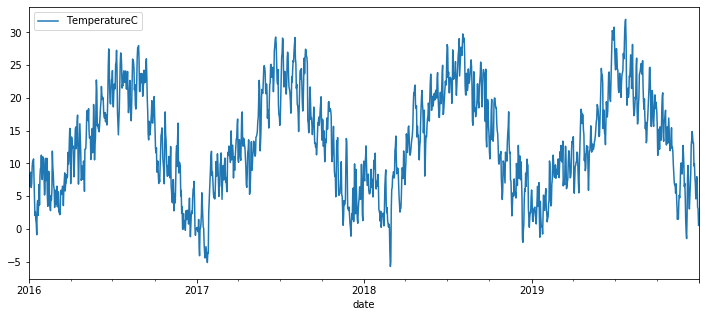

In [47]:
df.plot(figsize=(12,5))

Analyse stationarity

In [8]:

def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",   dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
ad_test(df['TemperatureC'])

1. ADF :  -2.4339813665843733
2. P-Value :  0.13237417226160014
3. Num Of Lags :  14
4. Num Of Observations Used For ADF Regression: 1446
5. Critical Values :
	 1% :  -3.434880391815318
	 5% :  -2.8635408625359315
	 10% :  -2.5678352438452814


Auto generate ARIMA parameters' orders

In [48]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['TemperatureC'], trace=True, seasonal=True, m=4, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=6482.357, Time=2.81 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=10106.080, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=6598.712, Time=0.91 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=7816.379, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=12122.668, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[4] intercept   : AIC=6472.008, Time=1.50 sec
 ARIMA(2,0,2)(0,0,0)[4] intercept   : AIC=6470.380, Time=0.86 sec
 ARIMA(2,0,2)(1,0,0)[4] intercept   : AIC=6474.726, Time=2.62 sec
 ARIMA(1,0,2)(0,0,0)[4] intercept   : AIC=6514.574, Time=0.37 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=6544.834, Time=0.50 sec
 ARIMA(3,0,2)(0,0,0)[4] intercept   : AIC=6469.808, Time=1.35 sec
 ARIMA(3,0,2)(1,0,0)[4] intercept   : AIC=6527.652, Time=4.04 sec
 ARIMA(3,0,2)(0,0,1)[4] intercept   : AIC=6471.576, Time=2.01 sec
 ARIMA(3,0,2)(1,0,1)[4] intercept   : AIC=6498.061, Time=2.83 sec
 ARIMA(3,0,1)(0,0,0)[4] interce

Split data for trainning and testing

In [49]:
print(df.shape)
train=df.iloc[:-30].copy()
test=df.iloc[-30:].copy()
print(train.shape,test.shape)

(1461, 1)
(1431, 1) (30, 1)


Train the model

In [51]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(train['TemperatureC'],order=(3,0,2), seasonal_order=(0,0,0,0), enforce_stationarity=False, enforce_invertibility=False,freq='D')   
model=model.fit()
model.summary()

/home/ec2-user/SageMaker/IoTAnalytics/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           TemperatureC   No. Observations:                 1431
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -3155.088
Date:                Mon, 07 Dec 2020   AIC                           6322.176
Time:                        01:12:47   BIC                           6353.761
Sample:                    01-01-2016   HQIC                          6333.972
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3871      0.080     17.409      0.000       1.231       1.543
ar.L2         -0.2223      0.147     -1.507      0.132      -0.511       0.067
ar.L3         -0.1656      0.076     -2.174      0.030      -0.315      -0.016
ma.L1         -0.3372      0.074     -4.584      0.000      -0.481      -0.193
ma.L2         -0.4923      0.074     -6.692      0.000      -0.637      -0.348
sigma2         4.8051      0.160     30.085      0.000       4.492       5.118
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               140.26
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.46
Prob(H) (two-sided):                  0.52   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Plot the results

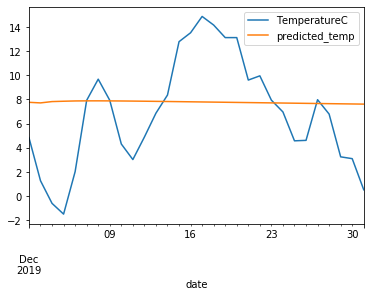

In [52]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
test['predicted_temp'] = pred.tolist()
test.plot(legend=True)

Process RMSE

In [53]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['TemperatureC'].mean()
rmse=sqrt(mean_squared_error(pred,test['TemperatureC']))
print(rmse, df['TemperatureC'].mean())

4.52975889181115 13.256872575861296


In [54]:
test

,TemperatureC,predicted_temp
date,,
2019-12-02 00:00:00+00:00,4.8375,7.760469
2019-12-03 00:00:00+00:00,1.2750,7.711294
2019-12-04 00:00:00+00:00,-0.6000,7.820690
2019-12-05 00:00:00+00:00,-1.4875,7.849196
2019-12-06 00:00:00+00:00,2.0250,7.872557
2019-12-07 00:00:00+00:00,7.9250,7.880514
2019-12-08 00:00:00+00:00,9.6750,7.881639
2019-12-09 00:00:00+00:00,7.9250,7.877562
2019-12-10 00:00:00+00:00,4.3125,7.870341


<div style="height:60px;"><div style="height:7px;background-color:#20B3CD;width:100%;margin-top:20px;position:relative;"><img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="height:50px;width:50px;margin-top:-20px;position:absolute;margin-left:42%;"></div></div>